
## Лабораторная работа №1: Фильтр Блума
### Задание 1: Реализация фильтра Блума

In [220]:
import numpy as np
import pandas as pd
import seaborn as sns
import hashlib
import random
import matplotlib.pyplot as plt

In [221]:
class BloomFilter:
    def __init__(self, m, k):
        self.m = m
        self.k = k
        self.bit_array = np.zeros(m, dtype=bool)
        self.hash_functions = [self._create_hash_function(i) for i in range(k)]
    
    def _create_hash_function(self, seed):
        def hash_func(item):
            hasher = hashlib.sha256()
            hasher.update(f"{seed}".encode('utf-8'))
            hasher.update(str(item).encode('utf-8'))
            return int(hasher.hexdigest(), 16) % self.m
        return hash_func
    
    def add(self, item):
        for hf in self.hash_functions:
            self.bit_array[hf(item)] = True
    
    def contains(self, item):
        return all(self.bit_array[hf(item)] for hf in self.hash_functions)
    
    def union(self, other):
        if self.m != other.m or self.k != other.k:
            raise ValueError("Фильтры должны иметь одинаковые параметры m и k")
        new_bf = BloomFilter(self.m, self.k)
        new_bf.bit_array = np.logical_or(self.bit_array, other.bit_array)
        return new_bf
    
    def intersect(self, other):
        if self.m != other.m or self.k != other.k:
            raise ValueError("Фильтры должны иметь одинаковые параметры m и k")
        new_bf = BloomFilter(self.m, self.k)
        new_bf.bit_array = np.logical_and(self.bit_array, other.bit_array)
        return new_bf

In [222]:
def calculate_false_positive_rate(m, k, added_elements, test_elements):
    bf = BloomFilter(m, k)
    for elem in added_elements:
        bf.add(elem)
    return (sum(1 for elem in test_elements if bf.contains(elem)) / len(test_elements)) * 100

In [223]:
def generate_random_strings(n, seed=None):
    random.seed(seed)
    return [''.join(random.choices('abcdefghijklmnopqrstuvwxyz', k=10)) for _ in range(n)]

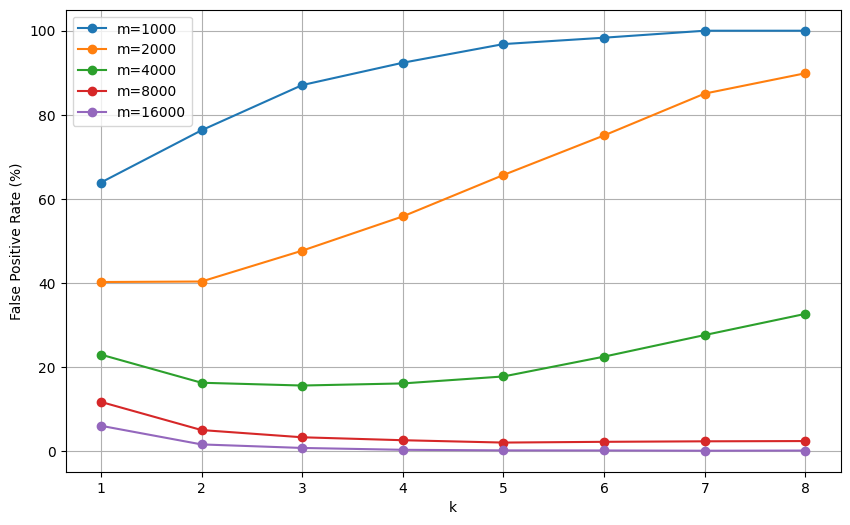

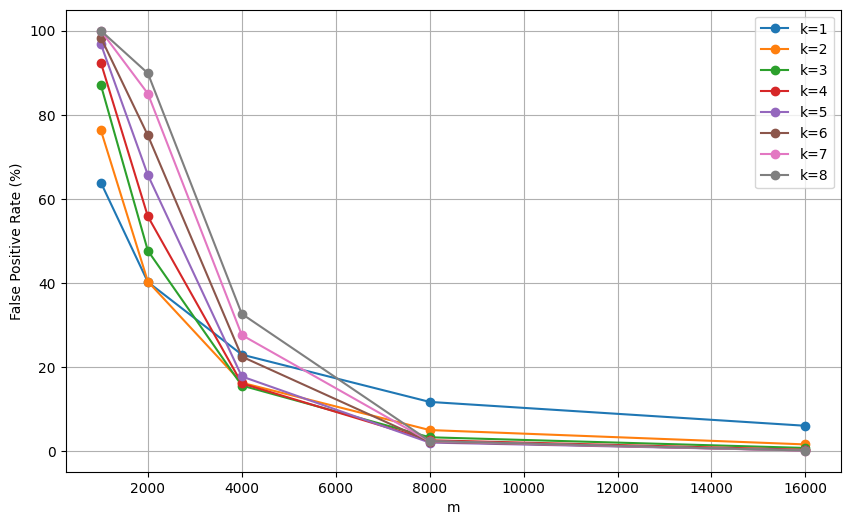

k          1      2      3      4      5      6       7       8
m                                                              
1000   63.86  76.30  87.06  92.38  96.82  98.34  100.00  100.00
2000   40.18  40.30  47.64  55.80  65.66  75.08   85.04   89.88
4000   22.90  16.20  15.54  16.04  17.70  22.42   27.56   32.60
8000   11.64   4.94   3.22   2.52   1.96   2.14    2.26    2.32
16000   5.96   1.52   0.68   0.24   0.10   0.08    0.02    0.06
Объединение содержит 'a' True
Объединение содержит 'b' True
Пересечение содержит 'a': False


In [224]:
n = 1000
test_size = 5000
m_values = [1000, 2000, 4000, 8000, 16000]
k_values = [1, 2, 3, 4, 5, 6, 7, 8]

added_elements = generate_random_strings(n)
test_elements = generate_random_strings(test_size)

assert len(set(added_elements) & set(test_elements)) == 0, "Тестовые элементы не должны пересекаться с добавленными"

results = []
for m in m_values:
    for k in k_values:
        rate = calculate_false_positive_rate(m, k, added_elements, test_elements)
        results.append({'m': m, 'k': k, 'false_positive_rate': rate})

df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
for m in m_values:
    subset = df[df['m'] == m]
    plt.plot(subset['k'], subset['false_positive_rate'], marker='o', label=f'm={m}')
plt.xlabel('k')
plt.ylabel('False Positive Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
for k in k_values:
    subset = df[df['k'] == k]
    plt.plot(subset['m'], subset['false_positive_rate'], marker='o', label=f'k={k}')
plt.xlabel('m')
plt.ylabel('False Positive Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

print(df.pivot(index='m', columns='k', values='false_positive_rate'))

# Пример операций с фильтрами
bf1 = BloomFilter(1000, 3)
bf1.add("a")
bf2 = BloomFilter(1000, 3)
bf2.add("b")

bf_union = bf1.union(bf2)
print("Объединение содержит 'a'", bf_union.contains("a"))
print("Объединение содержит 'b'", bf_union.contains("b"))
bf_intersection = bf1.intersect(bf2)
print("Пересечение содержит 'a':", bf_intersection.contains("a"))

### Задание 2: Реализация фильтра Блума со счётом

In [225]:
class CountingBloomFilter:
    def __init__(self, m, k):
        self.m = m  
        self.k = k  
        self.counters = np.zeros(m, dtype=int)
        self.hash_functions = [self._create_hash_function(seed) for seed in range(k)]
    
    def _create_hash_function(self, seed):
        def hash_func(item):
            hasher = hashlib.sha256()
            hasher.update(f"{seed}".encode('utf-8'))
            hasher.update(str(item).encode('utf-8'))
            return int(hasher.hexdigest(), 16) % self.m
        return hash_func
    
    def add(self, item):
        for hf in self.hash_functions:
            index = hf(item)
            self.counters[index] += 1
    
    def remove(self, item):
        for hf in self.hash_functions:
            index = hf(item)
            if self.counters[index] > 0:
                self.counters[index] -= 1
    
    def contains(self, item):
        return all(self.counters[hf(item)] > 0 for hf in self.hash_functions)
    
    def union(self, other):
        if self.m != other.m or self.k != other.k:
            raise ValueError("Фильтры должны иметь одинаковые параметры m и k")
        new_cbf = CountingBloomFilter(self.m, self.k)
        new_cbf.counters = np.maximum(self.counters, other.counters)
        return new_cbf
    
    def intersect(self, other):
        if self.m != other.m or self.k != other.k:
            raise ValueError("Фильтры должны иметь одинаковые параметры m и k")
        new_cbf = CountingBloomFilter(self.m, self.k)
        new_cbf.counters = np.minimum(self.counters, other.counters)
        return new_cbf


In [226]:
def calculate_false_positive_rates(cbf, added_items, removed_items, test_items):
    fp_add = sum(1 for item in test_items if cbf.contains(item))
    fp_add_rate = (fp_add / len(test_items)) * 100 if test_items else 0.0
    
    fp_remove = sum(1 for item in removed_items if cbf.contains(item))
    fp_remove_rate = (fp_remove / len(removed_items)) * 100 if removed_items else 0.0
    
    return fp_add_rate, fp_remove_rate

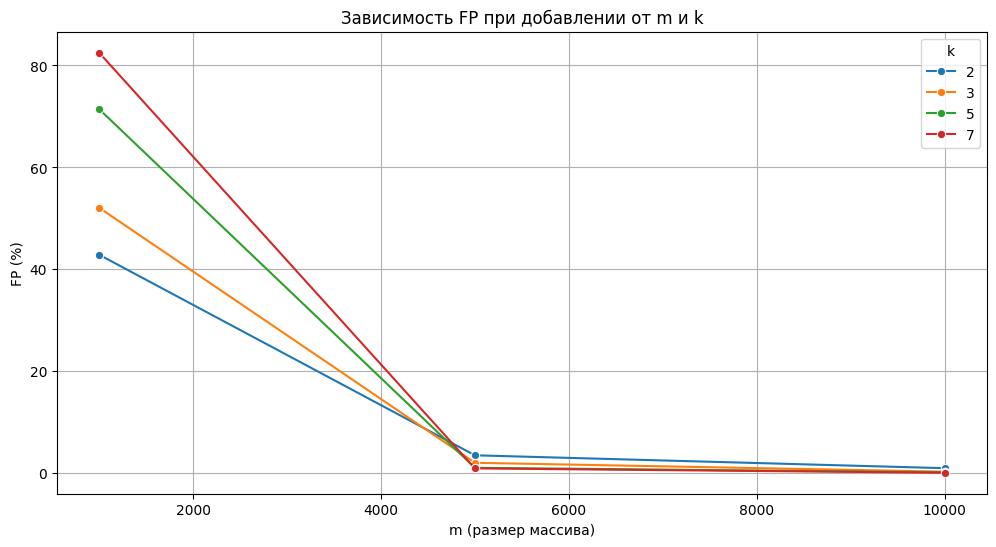

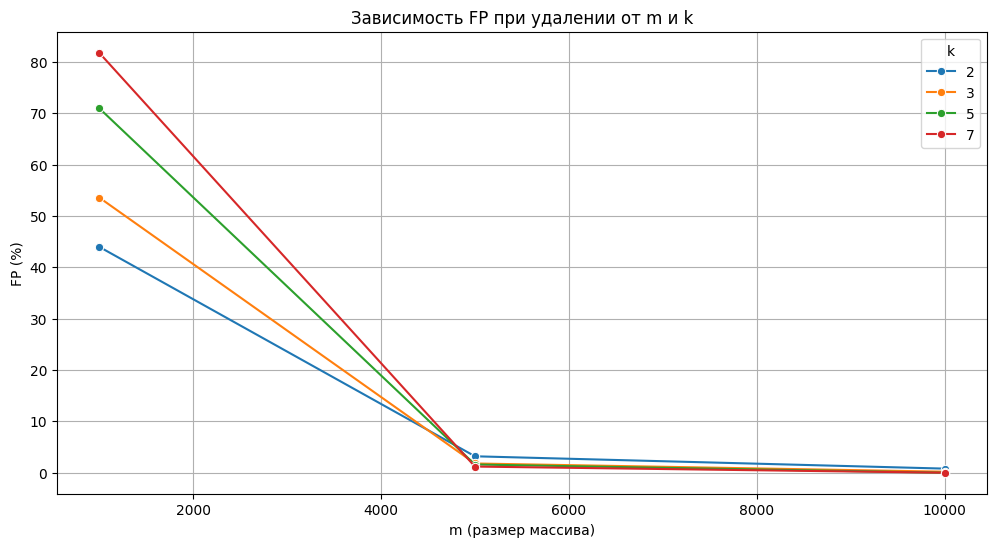

      FP Add (%)                      FP Remove (%)                  
k              2      3      5      7             2     3     5     7
m                                                                    
1000       42.82  52.04  71.40  82.48          44.0  53.6  71.0  81.8
5000        3.45   1.98   1.00   0.88           3.2   1.8   1.6   1.2
10000       0.92   0.24   0.11   0.03           0.8   0.2   0.0   0.0


In [227]:
m_values = [1000, 5000, 10000]
k_values = [2, 3, 5, 7]
num_elements = 1000
num_removed = 500
num_test_elements = 10000


added_items = list(range(num_elements))
removed_items = added_items[:num_removed]
test_items = list(range(num_elements, num_elements + num_test_elements))

assert not set(added_items).intersection(test_items), "Тестовые элементы не должны пересекаться с добавленными"

results = []
for m in m_values:
    for k in k_values:
        cbf = CountingBloomFilter(m, k)
        
        for item in added_items:
            cbf.add(item)
        
        for item in removed_items:
            cbf.remove(item)
        
        fp_add, fp_remove = calculate_false_positive_rates(cbf, added_items, removed_items, test_items)
        results.append({
            'm': m,
            'k': k,
            'FP Add (%)': fp_add,
            'FP Remove (%)': fp_remove
        })

df = pd.DataFrame(results)

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='m', y='FP Add (%)', hue='k', marker='o', palette='tab10')
plt.title('Зависимость FP при добавлении от m и k')
plt.xlabel('m (размер массива)')
plt.ylabel('FP (%)')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='m', y='FP Remove (%)', hue='k', marker='o', palette='tab10')
plt.title('Зависимость FP при удалении от m и k')
plt.xlabel('m (размер массива)')
plt.ylabel('FP (%)')
plt.grid(True)
plt.show()

print(df.pivot_table(index='m', columns='k', values=['FP Add (%)', 'FP Remove (%)']))